## Import statements

In [1]:
import plate_utils
import sys
import os
import glob
import numpy as np
from astropy.io import fits, ascii
from astropy import wcs
from matplotlib import cm
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import scipy.ndimage as nd
import scipy.optimize as opt
from scipy.spatial import distance as dt
import pandas as pd
import time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column
import pathlib
import tensorflow as tf
from tensorflow import keras
import sep
import SciServer
from SciServer import CasJobs     # Communicate between SciServer Compute and CasJobs
from astroquery.gaia import Gaia

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


## Functions

In [2]:
def gaussian_x(x, height, center, width, bgoffset):
#Returns a gaussian function with the given parameters
    width = float(width)
    return (height*np.exp(-((((x - center)/width)**2)/ 2.))) + bgoffset

In [3]:
def gauss_compare(dr, sl, g_dex):
    plt.plot(dr, sl[g_dex])
    plt.plot(dr, [gaussian_x(f, gaussian_fits[g_dex][0], gaussian_fits[g_dex][1], gaussian_fits[g_dex][2], gaussian_fits[g_dex][3]) for f in dr])

### Specify data path

In [4]:
datapath = '../Methods Paper/'
pathlib.Path(datapath + 'data_tables').mkdir(exist_ok=True)

### Display files in path

In [9]:
files = glob.glob(datapath + '*.fit*')
files = [os.path.basename(path) for path in files]
plate_utils.index_print(files)

0 f0015.fits
1 f0005.fits


### Print name of current file

In [10]:
whichfile = 0
extensionless_name = files[whichfile][:files[whichfile].find('.')]
print('whichfile =',files[whichfile])

whichfile = f0015.fits


### Display bit range of current file

In [11]:
currentfile = datapath + files[whichfile]
fits.info(currentfile)
hdul = fits.open(currentfile)
original_image_data = hdul[0].data
if hdul[0].header['NAXIS'] == 3:
    print("COLOR IMAGE")
    original_image_data = original_image_data[0]
bits = hdul[0].header['BITPIX']

Filename: ../Methods Paper/f0015.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     207   (3838, 3843, 3)   int16 (rescales to uint16)   
COLOR IMAGE


### Display file image

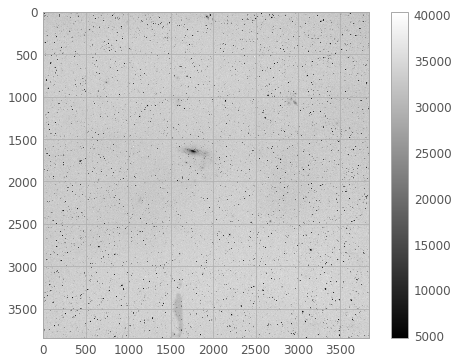

In [12]:
image_data = np.array(np.copy(original_image_data))
plt.figure()
plt.imshow(image_data, cmap='gray')
plt.colorbar()

### Convert to positive

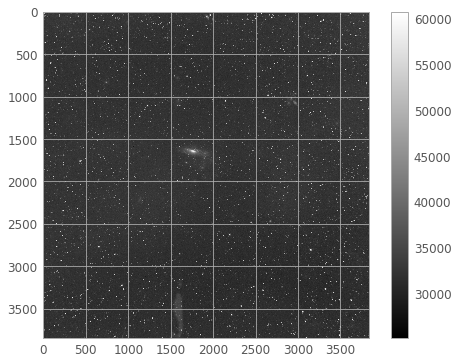

In [13]:
negative = True
if negative:
    bit_maximum = (1 << bits) - 1
    image_data = bit_maximum - image_data
    plt.figure()
    plt.imshow(image_data, cmap='gray')
    plt.colorbar()

### Crop image

In [14]:
crop_check = False
if crop_check:
    x_bounds = (1000, 2500)
    y_bounds = (1000, 2500)
    image_data = crop(image_data, x_bounds[0], y_bounds[0], x_bounds[1], y_bounds[1])
    print(np.shape(image_data))
    plt.figure()
    plt.imshow(image_data, cmap='gray')
    plt.colorbar()
else:
    x_bounds = (0, 0)
    y_bounds = (0, 0)

### Background subtraction

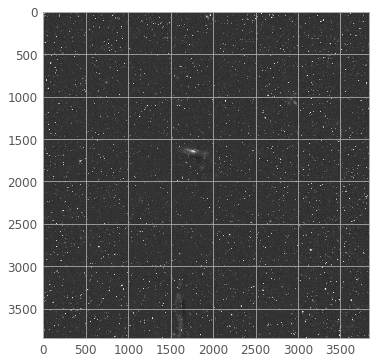

In [15]:
bkg = sep.Background(image_data.astype('float'))
plt.imshow(bkg, cmap='gray')
image_data = image_data - bkg
plt.imshow(image_data, cmap='gray')
hdul[0].data = image_data
hdul.writeto(datapath + '/bkg_' + files[whichfile], overwrite="True")

### Get plate specs

In [16]:
plate_median = np.median(image_data)
plate_width = len(image_data)
if crop_check:
    plate_center = ((np.shape(original_image_data)[1] / 2) - x_bounds[0], (np.shape(original_image_data)[0] / 2) - y_bounds[0])
else:
    plate_center = (np.shape(original_image_data)[1] / 2, np.shape(original_image_data)[0] / 2)

### Query star catalogs

In [ ]:
help(SDSS_query)

In [18]:
coords = wcs.WCS(hdul[0].header)
if(crop_check):
    coord_bounds = [(x_bounds[0], y_bounds[0]), (x_bounds[1], y_bounds[0]), (x_bounds[0], y_bounds[1]), (x_bounds[1], y_bounds[1])]
else:
    coord_bounds = [(0, 0), (len(image_data[0]), 0), (0, len(image_data)), (len(image_data[0]), len(image_data))]
wcs_bounds = coords.all_pix2world(np.asarray(coord_bounds), 1)
wcs_center = coords.all_pix2world([plate_center], 1)[0]
wcs_bounds_to_center = []
ra_bounds = []
dec_bounds = []
for bound in wcs_bounds:
    ra_bounds.append(bound[0])
    dec_bounds.append(bound[1])
    wcs_bounds_to_center.append(np.hypot(bound[0] - wcs_center[0], bound[1] - wcs_center[1]))
plate_width_wcs = np.mean(wcs_bounds_to_center) * np.sqrt(2)
print("Plate width (degrees): " + str(plate_width_wcs))

gaia_check = False
SDSS_check = True
if gaia_check:
    star_info_gaia = gaia_query_box(np.amin(ra_bounds), np.amax(ra_bounds), np.amin(dec_bounds), np.amax(dec_bounds), threshold=16)
    star_info_gaia.sort('phot_bp_mean_mag')
    star_info_gaia_coords = [(star_info_gaia['ra'][i], star_info_gaia['dec'][i]) for i in range(len(star_info_gaia))]
    star_info_gaia.write(datapath + '/data_tables/gaia_query.csv', format='csv', overwrite=True)
    print("Gaia stars found: " + str(len(star_info_gaia)))
if SDSS_check:
    star_info_SDSS_pandas = SDSS_query(np.amin(ra_bounds), np.amax(ra_bounds), np.amin(dec_bounds), np.amax(dec_bounds), threshold=20, num_stars=40000)
    star_info_SDSS = Table.from_pandas(star_info_SDSS_pandas)
    star_info_SDSS.sort('g')
    star_info_SDSS_coords = [(star_info_SDSS['ra'][j], star_info_SDSS['dec'][j]) for j in range(len(star_info_SDSS))]
    star_info_SDSS.write(datapath + '/data_tables/SDSS_query.csv', format='csv', overwrite=True)
    print("SDSS stars found: " + str(len(star_info_SDSS)))

Plate width (degrees): 1.6410573107332327


NameError: name 'SDSS_query' is not defined

In [24]:
if gaia_check:
    star_info_gaia = ascii.read(datapath + "/data_tables/gaia_query.csv", format='csv', fast_reader=False)
    star_info_gaia.sort('phot_bp_mean_mag')
    star_info_gaia_coords = [(star_info_gaia['ra'][i], star_info_gaia['dec'][i]) for i in range(len(star_info_gaia))]

### Extract plate objects

Objects detected:  2216


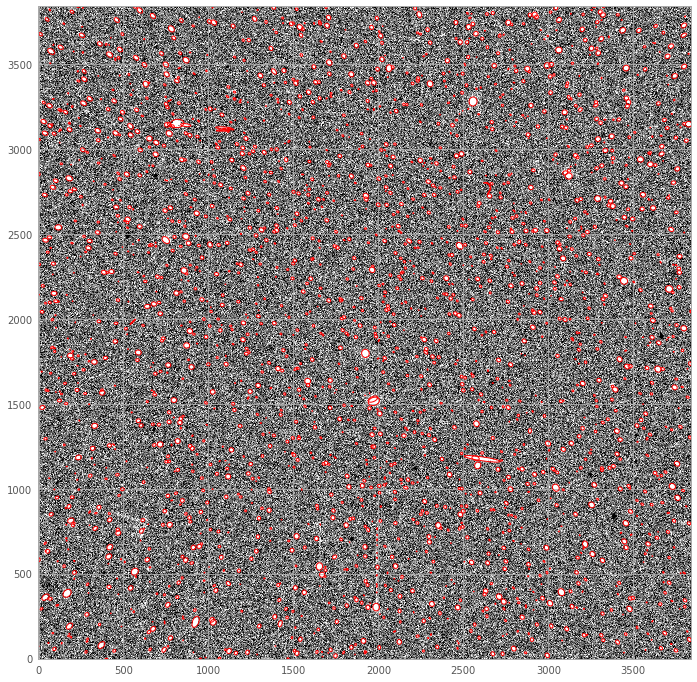

In [44]:
sigma = 3
objects = sep.extract(image_data.astype('float'), sigma, err=bkg.globalrms)
object_pix_locs = [[objects['x'][i] + x_bounds[0], objects['y'][i] + y_bounds[0]] for i in range(len(objects))]
object_coords = np.array(coords.all_pix2world(object_pix_locs, 1))
object_ra = [object_coords[i][0] for i in range(len(objects))]
object_dec = [object_coords[i][1] for i in range(len(objects))]
print("Objects detected: ", len(objects))

sep_table = Table()
sep_table['x'] = objects['x']
sep_table['y'] = objects['y']
sep_table['ra'] = object_ra
sep_table['dec'] = object_dec
sep_table.write(datapath + '/data_tables/' + extensionless_name + '_sep.csv', format='csv', overwrite=True)

from matplotlib.patches import Ellipse

data_sub = np.copy(image_data)

# plot background-subtracted image
fig, ax = plt.subplots(figsize=(12,12))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

### Match plate objects to catalog

In [47]:
start_time_fast = time.time()
if gaia_check:
    fast_matches = quick_match(object_coords, star_info_gaia_coords, 0.1, 0.5)
if SDSS_check:
    fast_matches = quick_match(object_coords, star_info_SDSS_coords, 0.1, 0.5)   
elapsed_time_fast = time.time() - start_time_fast
print("Time: " + str(elapsed_time_fast))

Time: 1.4288067817687988


### Aperture photometry

In [48]:
radius_unit = plate_width / plate_width_wcs
aperture_radius = 0.004 * radius_unit
buffer_radius = 0.006 * radius_unit
background_radius = 0.008 * radius_unit
aperture_area = (np.pi * (aperture_radius ** 2))
buffer_area = (np.pi * (buffer_radius ** 2))
background_area = (np.pi * (background_radius ** 2)) - buffer_area
constant = 22.5
print("Aperture radius: ", aperture_radius)
print("Buffer radius: ", buffer_radius)
print("Background radius: ", background_radius)

aperture_list, aperture_list_err, aperture_list_flag = sep.sum_circle(data_sub, objects['x'], objects['y'], aperture_radius, err=bkg.globalrms, gain=1.0)
background_list, background_list_err, background_list_flag = sep.sum_circann(data_sub, objects['x'], objects['y'], buffer_radius, background_radius, err=bkg.globalrms, gain=1.0)
background_densities = [annulus_sum / background_area for annulus_sum in background_list]
fluxes = np.array([aperture_list[i] - (aperture_area * background_densities[i]) for i in range(len(aperture_list))])
nan_mask = fluxes < 0
calculated_mags = constant - 2.5*np.log10(fluxes)

Aperture radius:  8.37584038416829
Buffer radius:  12.563760576252436
Background radius:  16.75168076833658


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


In [52]:
if gaia_check:
    master_table = star_info_gaia[fast_matches]
if SDSS_check:
    master_table = star_info_SDSS[fast_matches]
master_table['flux'] = fluxes
master_table['calculated_mags'] = calculated_mags
master_table['plate_ra'] = object_coords[:, 0]
master_table['plate_dec'] = object_coords[:, 1]
master_table['plate_x'] = objects['x']
master_table['plate_y'] = objects['y']
master_table.remove_rows(np.arange(0, len(nan_mask))[nan_mask])
clean_mask = master_table['clean'] == 0
master_table.remove_rows(np.arange(0, len(clean_mask))[clean_mask])
print(len(master_table))

1053


In [53]:
master_table['umg'] = master_table['u'] - master_table['g']
master_table['gmp'] = master_table['g'] - master_table['calculated_mags']
#SDSS_corrected = [SDSS_mags_g[i] * (0.2 * (SDSS_mags_u[i] - SDSS_mags_g[i])) for i in range(len(SDSS_mags_g))]

master_table.write(datapath + '/data_tables/' + extensionless_name + '_matched.csv', format='csv', overwrite=True)

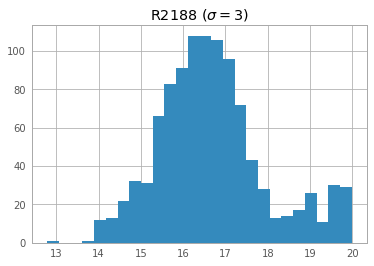

In [57]:
plt.title(extensionless_name.split('_')[0] + r' ($\sigma = $' + str(sigma) + ")")
plt.hist(master_table['g'], bins='auto')
plt.savefig(datapath + '/' + extensionless_name + '_hist.png')

In [ ]:
plt.figure(figsize=(11.5, 11.5))
# plt.ylim(5.3, 6.4)
# plt.xlim(14.9, 18)
plt.gca().invert_yaxis()
plt.gca().set_ylabel('log10(flux)')
plt.gca().set_xlabel('SDSS g magnitudes')
plt.scatter(master_table['g'], master_table['calculated_mags'], c='red')

In [ ]:
plt.figure(figsize=(11.5, 11.5))
plt.gca().set_ylabel('u - g')
plt.gca().set_xlabel('g - plate')
# plt.xlim(0.75, 2)
plt.ylim(7, 10)
# plt.gca().set_ylabel('u - g')
# plt.gca().set_xlabel('g - plate')
plt.scatter(master_table['umg'], master_table['gmp'])

In [ ]:
def color_correction(x):
    h1 = 0.9
    k1 = 8.7
    h2 = 2.
    k2 = 8.1
    slope = (k2 - k1) / (h2 - h1)
    return (slope*(h1 - x)) + k1

master_table['color_correction'] = color_correction(np.array(master_table['g']))
master_table['corrected_mags'] = master_table['color_correction'] + master_table['calculated_mags']

plt.figure(figsize=(11.5, 11.5))
# plt.ylim(5.3, 6.4)
# plt.xlim(14.9, 18)
plt.gca().invert_yaxis()
plt.gca().set_ylabel('SDSS g magnitudes')
plt.gca().set_xlabel('log10(flux)')
plt.scatter(master_table['corrected_mags'], master_table['g'], c='red')

In [ ]:
import scipy.stats
slope_cal, intercept_cal, r_value, p_value, std_err = scipy.stats.linregress(master_table['corrected_mags'], master_table['g'])
print(std_err)
def calibrate_mag(x):
    return (slope_cal * x) + intercept_cal

In [ ]:
# 1: 167.86885, 28.77947
# 2: 167.59673, 28.73918
# 3: 167.68761, 28.61742

three_coords = [(167.86876, 28.77950), (167.68729, 28.61764), (167.59663, 28.73876)]
three_ids = star_info_SDSS['objid'][quick_match(three_coords, star_info_SDSS_coords, 0.1, 0.5)]
three_mags = np.array([master_table['corrected_mags'][np.where(master_table['objid'] == i)][0] for i in three_ids])
# for three_id in three_ids:
#     objid_found = 0
#     for i in range(len(master_table)):
#         if master_table['objid'][i] == three_id:
#             three_mags.append(master_table['g'][i])
#             objid_found = 1
#     if not objid_found:
#         three_mags.append(-1)
print(three_mags)
print(calibrate_mag(three_mags))

### Gaussian fitting

In [ ]:
domain_half = 20
d_range = range(0 - domain_half, domain_half)
slices = []
gaussian_fits = []
for i in range(len(star_cm_locations)):
    if((star_x_cm_location[i] < (len(image_data[0]) - domain_half)) and (star_x_cm_location[i] > domain_half)):
        star_slice = image_data[int(star_y_cm_location[i])][int(star_x_cm_location[i] - domain_half) : int(star_x_cm_location[i] + domain_half)]
        slices.append(star_slice)
        params, params_cov = opt.curve_fit(gaussian_x, d_range, star_slice, [10000, 0, 1, plate_median])
        gaussian_fits.append(params)
gaussian_fits = np.asarray(gaussian_fits)

### CSV writing

In [ ]:
table_len = len(cleaned_gaia_mags)
preprocessing_table = Table()
# preprocessing_table['plate_median'] = np.full(table_len, plate_median)
# preprocessing_table['plate_width'] = np.full(table_len, plate_width)
# preprocessing_table['plate_width_wcs'] = np.full(table_len, plate_width_wcs)
# preprocessing_table['g_amplitude'] = gaussian_fits[:, 0]
# preprocessing_table['g_width'] = gaussian_fits[:, 2]
# preprocessing_table['g_background'] = gaussian_fits[:, 3]
preprocessing_tablele['gaia_flux'] = star_fluxes
preprocessing_table['gaia_mag'] = star_info_SDSS['g']
# preprocessing_table['SDSS_flux'] = star_fluxes
# preprocessing_table['SDSS_mag'] = star_info_SDSS['g']

preprocessing_table.write(datapath + '/data_tables/' + extensionless_name + '.csv', format='csv', overwrite=True)